In [37]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

class KRR(BaseEstimator, RegressorMixin):

    def __init__(self, kernel_func , sigma=None, lamb=None, kpca_ncmps=None, bst_mod = None):

        """
        User must provide a kernelfunction, 
        sigma and lambda are optinal for initialization
        """

        self.kernel_func  = kernel_func        # kernelfunction, no default
        self.sigma        = sigma or 1.0       # sigma value, 1 default
        self.lamb         = lamb  or 1e-7      # lambda value, 1e-7 default
        self.kpca_ncmps   = kpca_ncmps or 2    # number of components for kpca, 2 default
        self.bst_mod      = bst_mod or 0   
    
        
        
        
        """
        get_params and set_params are used by sklearn e.g. for hyperparameter
        optimization
        """

    def get_params(self, deep=True):

        return {"kernel_func":self.kernel_func,"sigma": self.sigma, "lamb": self.lamb}

    def set_params(self, **parameters):

        self.kernel_func   = parameters["kernel_func"]
        self.sigma         = parameters["sigma"]
        self.lamb          = parameters["lamb"]      
        
        
        return self

        """
        Obtain the regression coefficients alpha and
        save the training representations because they are 
        needed for predictions
        """
    
    def fit(self, X, y):

        Kernel_train  = self.kernel_func(X,X, self.sigma)

        for i in range(Kernel_train.shape[0]):
            Kernel_train[i, i] += self.lamb

   
        self.ALPHA_SOL = np.linalg.solve(Kernel_train, y)
        self.XTRAIN    = X
        
        return self
    
        """
        Make the predictions for query representations Xry
        """

    def predict(self, Xqry):

        Kernel_test     = self.kernel_func(self.XTRAIN, Xqry, self.sigma)
        pred            = np.dot(self.ALPHA_SOL, Kernel_test)
        
        return pred
    
        """
        Make a kernel-pca, by first going to kernel space and 
        performing a pca afterwards, by default 
        returns the first two components
        """



    """
    def cv_score(self, X, y):

        from sklearn.model_selection import cross_val_score
        kfold = 5
        if self.bst_mod==0:
           print("No model to validate") 
           exit()


        scores = cross_val_score(KRR(self.bst_mod.get_params()['krr__kernel_func'],self.bst_mod.get_params()['krr__sigma'],self.bst_mod.get_params()['krr__lamb']), X, y, scoring='neg_mean_absolute_error', cv=kfold)

        mae_scores = np.array([abs(s) for s in scores])
        mean_score = np.mean(mae_scores)
        print('MAE: {:.3f}'.format(mean_score))
        return mae_scores
    """



    def kpca(self, X):
        Kernel_train  = self.kernel_func(X,X, self.sigma)

        from sklearn.decomposition import PCA

        pca     = PCA(n_components=self.kpca_ncmps)
        kpca    = pca.fit_transform(Kernel_train)

        return kpca

**1 d funktion  Example**

In [38]:
import numpy as np
import numpy.linalg as LA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import numba
#from numba import jit
#from math import sqrt


#@jit
def fast_distance(xa, xb):

    if len(xa.shape) == 1:
        measure = abs
    else:
        measure = LA.norm


    dmat = np.zeros((len(xa),len(xb) ))

    if np.array_equal(xa, xb):
        for i in range(len(xa)):
            for j in range(i+1, len(xb)):
                #curr_d = sqrt((locs[i,0] - locs[j,0])**2 + (locs[i,1] - locs[j,1])**2 + (locs[i,2] - locs[j,2])**2)
                curr_d = measure(xa[i]-xb[j])
                dmat[i, j] = curr_d
                dmat[j, i] = curr_d

    else:
        for i in range(len(xa)):
            for j in range(len(xb)):
                curr_d = measure(xa[i]-xb[j])
                dmat[i, j] = curr_d

    return dmat




def kernel_1d_fct_laplace(Xa, Xb, sigma):

    dist = fast_distance(Xa, Xb)
    
    return np.exp(-sigma* dist)


def kernel_1d_fct_gauss(Xa, Xb, sigma):

    dist = fast_distance(Xa, Xb)
    
    return np.exp(-sigma* dist**2)    
    
ndata = 50
X = np.linspace(1, 7, ndata)
# make a function that is complicated to fit
y = -5 *np.exp(-X)*np.sin(-X)*np.cos(X**2)   +  np.random.normal(0,1e-8,ndata) #* np.exp(X**2+1) #*np.arctan(np.pi*X)


regressor = KRR(kernel_1d_fct_laplace)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,shuffle=True, random_state=666)
param_grid = [{"krr__sigma": [10**(i) for i in range(-4, 4)], "krr__lamb":[10**(i) for i in range(-8, -1)], "krr__kernel_func": [kernel_1d_fct_laplace,kernel_1d_fct_gauss ]}]
pipe = Pipeline([ ('krr', regressor) ])
grid_search = 0
grid_search = GridSearchCV(pipe, param_grid, cv = 5, return_train_score=True, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print(best_model['krr'])
print(best_model['krr'].sigma)
print(best_model['krr'].lamb)
y_pred = best_model['krr'].predict(X_test)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
KRR(kernel_func=<function kernel_1d_fct_gauss at 0x7f1cd7dcb9d8>, lamb=1e-08,
    sigma=10)
10
1e-08


In [39]:
np.mean(np.abs(y_pred-y_test))

0.054273207745886405

In [40]:
regressor.bst_mod = best_model

In [41]:
regressor.bst_mod

Pipeline(steps=[('krr',
                 KRR(kernel_func=<function kernel_1d_fct_gauss at 0x7f1cd7dcb9d8>,
                     lamb=1e-08, sigma=10))])

In [42]:
regressor.cv_score(X, y)

AttributeError: 'KRR' object has no attribute 'cv_score'

In [35]:
print(best_model.get_params()['krr__kernel_func'])
print(best_model.get_params()['krr__sigma'])
print(best_model.get_params()['krr__lamb'])


<function kernel_1d_fct_gauss at 0x7f1cd7e2f2f0>
10
1e-08


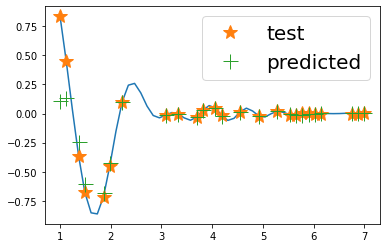

In [36]:
plt.plot(X, y, "-")
plt.plot( X_test, y_test,  "*",ms=15,label='test')
plt.plot( X_test, y_pred,  "+",ms=15,label='predicted')
plt.legend(fontsize=20)

In [18]:
grid_search.

TypeError: 'NoneType' object is not callable

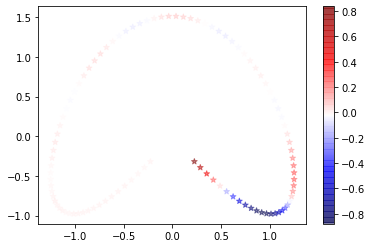

In [6]:
fig, ax = plt.subplots()
regressor.kpca_ncmps = 3
two_dim = regressor.kpca(X)
formation = ax.scatter(two_dim[:,0],two_dim[:,1],marker="*", c=y,vmin=np.min(y), vmax=np.max(y), alpha=0.5, cmap='seismic')
cbar = fig.colorbar(formation, ax=ax)